## 7.5.3从零实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X,gamma,beta,moving_mean,moving_var,eps,momentum):
    # 通过is_grad_enabled方法来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat=(X-moving_mean)/torch.sqrt(moving_var)
    else:
        assert len(X.shape) in (2,4)
        if len(X.shape)==2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean=X.mean(dim=0)
            var=((X-mean)**2).mean(dim=0)
        else:
            # 使用二维卷积的情况，计算通道维上(axis=1)的均值和方差
            # 需要保持X的形状以便后面可以做广播运输
            mean=X.mean(dim=(0,2,3),keepdim=True)
            var=((X-mean)**2).mean(dim=(0,2,3),keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat=(X-mean)/torch.sqrt(var+eps)
        # 更新移动平均的均值和方差
        moving_mean=momentum*moving_mean+(1.0-momentum)*mean
        moving_var=momentum*moving_var+(1.0-momentum)*var
    Y=gamma*X_hat+beta  # 缩放和移位
    return Y,moving_mean.data,moving_var.data

In [2]:
class BatchNorm(nn.Module):
    # num_features:全连接层的输出数量或卷积层的输出通道数
    # num_dims:2表示全连接层，4 表示卷积层
    def __init__(self,num_features,num_dims):
        super().__init__()
        if num_dims==2:
            shape=(1,num_features)
        else:
            shape=(1,num_features,1,1)
        # 参与求梯度和迭代的拉伸参数和偏移参数，其分别初始化为1和0
        self.gamma=nn.Parameter(torch.ones(shape))
        self.beta=nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean=torch.zeros(shape)
        self.moving_var=torch.ones(shape)
    
    def forward(self,X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在的显存上
        if self.moving_mean.device!=X.device:
            self.moving_mean=self.moving_mean.to(X.device)
            self.moving_var=self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y,self.moving_mean,self.moving_var=batch_norm(X,self.gamma,self.beta,self.moving_mean,self.moving_var,eps=1e-5,momentum=0.9)
        return Y

## 7.5.4使用批量规范化层的LeNet

In [3]:
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),
    BatchNorm(6,num_dims=4),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),
    BatchNorm(16,num_dims=4),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*4*4,120),
    BatchNorm(120,num_dims=2),
    nn.Sigmoid(),
    nn.Linear(120,84),
    BatchNorm(84,num_dims=2),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

loss 0.266, train acc 0.901, test acc 0.757
46421.8 examples/sec on cuda:0


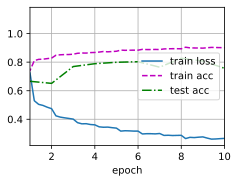

In [4]:
lr,num_epochs,batch_size=1.0,10,256
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())

In [5]:
net[1].gamma.reshape((-1,)),net[1].beta.reshape((-1,))

(tensor([3.0751, 2.9760, 1.5584, 2.5487, 2.8323, 3.8001], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-1.2550,  3.2111, -1.0211, -1.7506,  1.9792,  2.2752], device='cuda:0',
        grad_fn=<ViewBackward0>))

## 7.5.5简明实现

In [6]:
net=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5),
    nn.BatchNorm2d(6),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(256,120),
    nn.BatchNorm1d(120),
    nn.Sigmoid(),
    nn.Linear(120,84),
    nn.BatchNorm1d(84),
    nn.Sigmoid(),
    nn.Linear(84,10)
)

loss 0.271, train acc 0.899, test acc 0.852
55662.3 examples/sec on cuda:0


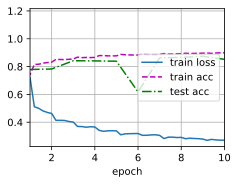

In [7]:
d2l.train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())